In [81]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
from keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Reshape, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv('data.txt')

In [ ]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


In [ ]:
def read_stop_words(filename):
  with open(filename) as stopwords_file:
    stopwords = stopwords_file.readlines()
  stopwords = [line.replace('\n', '') for line in stopwords] 
  return stopwords

In [ ]:
stopwords = read_stop_words('stopwords.txt')
print(len(stopwords))

1382


In [ ]:
# install hazm library
!pip install hazm
from hazm import word_tokenize

In [ ]:
# preprocess the text
def text_preprocess(data):
  text = [line.replace('\t', ' ') for line in data.values.flatten()]
  text = [line.replace('-', ' ') for line in text]
  text = [re.sub("\d+", "", t) for t in text]

  word_tokenized = [word_tokenize(t) for t in text]
  word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

  sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
  sentences = [sentence for sentence in sentences if sentence != '']

  return sentences


In [ ]:
sentences = text_preprocess(data)

In [ ]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

In [ ]:
def get_all_sentences():
  all_sentences = ''
  sentences = text_preprocess(data)
  for sentence in sentences:
    all_sentences += sentence
    all_sentences += ' '

  return all_sentences  

In [ ]:
def get_word_freq(vocabularies):
  word_freq = []
  for vocab in vocabularies:
    word_freq.append(vocabularies.count(vocab))
  return word_freq  

In [ ]:
# get the words that frequentes less than 3 times in the corpus
def get_less_frequente_words():
  low_frequency_words = []
  all_sentences = get_all_sentences()
  vocabularies = all_sentences.split(' ')
  word_freq = get_word_freq(vocabularies)

  for i in range(len(word_freq)):
    if word_freq[i] < 3:
      low_frequency_words.append(vocabularies[i])

  return low_frequency_words

In [ ]:
less_frequente_words = get_less_frequente_words()

In [ ]:
print(len(less_frequente_words))

9508


In [ ]:
# remove the words that frequentes less than 3 times in the corpus
def remove_less_frequente_words(less_frequente_words, sentences):
  sentences_tokenized = [word_tokenize(sentence) for sentence in sentences]
  sentences_tokenized_filtered = [[w for w in sentence if w not in less_frequente_words] for sentence in sentences_tokenized]
  corpus = [' '.join(sentence) for sentence in sentences_tokenized_filtered]
  corpus = [sentence for sentence in corpus if sentence != '']

  return corpus

In [ ]:
corpus = remove_less_frequente_words(less_frequente_words, sentences)

In [ ]:
corpus[0]

'رحمت منتها آتشی افروخته بیشه اندیشه'

In [ ]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [82]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
print(tokenizer.word_index)

{'جان': 1, 'دل': 2, 'عشق': 3, 'آب': 4, 'چشم': 5, 'شب': 6, 'جهان': 7, 'شمس': 8, 'دست': 9, 'مست': 10, 'گل': 11, 'یار': 12, 'عقل': 13, 'جمله': 14, 'غم': 15, 'آتش': 16, 'نور': 17, 'مه': 18, 'خاک': 19, 'تن': 20, 'عالم': 21, 'تبریز': 22, 'خدا': 23, 'شاه': 24, 'ره': 25, 'خانه': 26, 'باده': 27, 'عاشق': 28, 'تویی': 29, 'روح': 30, 'ساقی': 31, 'خون': 32, 'ماه': 33, 'کف': 34, 'رخ': 35, 'لطف': 36, 'شکر': 37, 'پا': 38, 'زر': 39, 'آسمان': 40, 'گوش': 41, 'عاشقان': 42, 'زمین': 43, 'بحر': 44, 'ذره': 45, 'خورشید': 46, 'سخن': 47, 'چرخ': 48, 'گرد': 49, 'پرده': 50, 'باغ': 51, 'جام': 52, 'تبریزی': 53, 'دین': 54, 'آرزوست': 55, 'پای': 56, 'خواب': 57, 'آفتاب': 58, 'گشت': 59, 'سو': 60, 'یوسف': 61, 'درد': 62, 'دوست': 63, 'بنده': 64, 'دریا': 65, 'نفس': 66, 'شمع': 67, 'روان': 68, 'شراب': 69, 'دلم': 70, 'هوا': 71, 'برو': 72, 'زبان': 73, 'ببین': 74, 'پنهان': 75, 'سنگ': 76, 'دهان': 77, 'گشته': 78, 'ای': 79, 'وقت': 80, 'وفا': 81, 'بوی': 82, 'رسد': 83, 'سجده': 84, 'خواجه': 85, 'خمش': 86, 'سایه': 87, 'خار': 88, 'نقش': 89

In [ ]:
 # find more stopwords by sorting the tokenizer word counts
#  word_count_sorted = dict(sorted(tokenizer.word_counts.items(), reverse=False, key=lambda t: t[1]))
#  word_count_sorted

In [ ]:
encoded = tokenizer.texts_to_sequences(corpus)

In [ ]:
encoded

[[283, 1332, 395, 1605, 961, 142],
 [185, 565, 1118, 396, 565, 565, 826, 332, 23],
 [46, 29, 633, 2025, 29, 827, 29, 258, 29, 1332],
 [92, 142, 1333, 723, 724],
 [30, 221, 162, 397, 1606, 962, 244],
 [1606, 725, 2026, 566, 10, 10, 209],
 [464, 13, 464, 209, 1119, 417],
 [963, 104, 1607, 350, 1120, 1607, 192, 1607, 726],
 [75, 41, 1, 397, 1608, 1, 259, 245, 284, 1121],
 [201, 727, 56, 221, 375, 728, 1122, 31, 567, 186],
 [1609, 465, 466, 143, 285],
 [2027, 1610, 222, 150],
 [634, 2028, 19, 223, 32, 1334, 1335, 33, 568],
 [144, 15, 2, 306, 1123],
 [1124, 202],
 [506, 1336, 376, 1, 78, 398],
 [466, 1611, 2029],
 [2030, 88, 88, 39, 105, 2031],
 [1612, 2032, 506, 1612, 398, 1612, 2033, 1612, 635],
 [636, 21, 1337, 377, 21, 2034, 828, 1338, 1613],
 [8, 2035, 2036, 106, 3, 2037, 210, 166, 1614, 3, 307, 2037],
 [308, 74, 18, 1339, 829, 11],
 [3, 830, 1125, 507],
 [3, 467, 3, 637, 3, 78, 2038, 831, 3, 831, 2038],
 [4, 124, 47, 221, 1, 964, 2039],
 [418, 203, 47, 2040, 418, 47, 2040],
 [65, 224,

In [ ]:
num_all_words = sum(len(s) for s in encoded) # total number of words in the corpus
num_unique_words = len(tokenizer.word_index) + 1  # total number of unique words in the corpus

In [ ]:
num_all_words, num_unique_words

(29456, 2722)

In [ ]:
# Parameters
window_size = 2

In [ ]:
def generate_data(corpus, window_size, num_unique_words):
    maxlen = window_size * 2
    all_inputs = []
    all_outputs = []
    for words in corpus:
      len_words = len(words)
      for index,w in enumerate(words):
        s = index - window_size
        e = index + window_size + 1
        for i in range(s, e):
            if i != index and 0 <= i < len_words:
              all_inputs.append(w)      
              all_outputs.append(to_categorical(words[i], num_unique_words))

    return (np.array(all_inputs), np.array(all_outputs))

In [ ]:
# Create training data
X_train, y_train = generate_data(encoded, window_size, num_unique_words)
X_train.shape, y_train.shape

((86230,), (86230, 2722))

In [ ]:
X_train, y_train

(array([ 283,  283, 1332, ...,  616, 1806, 1806]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
dim = 50
# create model
model = Sequential()
model.add(Embedding(num_unique_words, dim, input_length=1, embeddings_initializer='glorot_uniform'))
model.add(Reshape((dim,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(num_unique_words, activation='softmax', kernel_initializer='glorot_uniform'))

In [ ]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1, 50)             136100    
                                                                 
 reshape_7 (Reshape)         (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 30)                1530      
                                                                 
 dense_22 (Dense)            (None, 10)                310       
                                                                 
 dense_23 (Dense)            (None, 2722)              29942     
                                                                 
Total params: 167,882
Trainable params: 167,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=64, validation_split=0.2)

Epoch 1/50
1078/1078 [==============================] - 8s 7ms/step - loss: 7.3041 - accuracy: 0.0280 - val_loss: 7.4666 - val_accuracy: 0.0199
Epoch 2/50
1078/1078 [==============================] - 7s 6ms/step - loss: 7.1688 - accuracy: 0.0284 - val_loss: 7.5002 - val_accuracy: 0.0199
Epoch 3/50
1078/1078 [==============================] - 7s 6ms/step - loss: 7.1327 - accuracy: 0.0290 - val_loss: 7.5241 - val_accuracy: 0.0220
Epoch 4/50
1078/1078 [==============================] - 7s 6ms/step - loss: 7.0591 - accuracy: 0.0312 - val_loss: 7.5741 - val_accuracy: 0.0226
Epoch 5/50
1078/1078 [==============================] - 7s 7ms/step - loss: 6.9748 - accuracy: 0.0337 - val_loss: 7.6217 - val_accuracy: 0.0243
Epoch 6/50
1078/1078 [==============================] - 7s 7ms/step - loss: 6.8917 - accuracy: 0.0361 - val_loss: 7.7172 - val_accuracy: 0.0235
Epoch 7/50
1078/1078 [==============================] - 7s 7ms/step - loss: 6.8112 - accuracy: 0.0381 - val_loss: 7.7846 - val_accuracy:

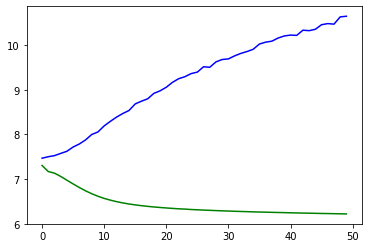

In [ ]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')

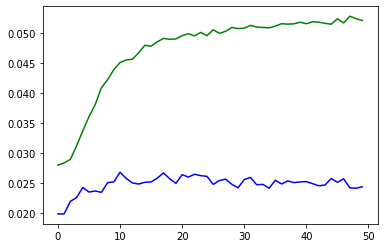

In [ ]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')

In [ ]:
model.save('word2vec.h5')

In [ ]:
# laod model
model = load_model('word2vec.h5')

In [ ]:
model

In [ ]:
weights = model.get_weights()

In [ ]:
weights[0][1]

array([-0.15095727, -0.02524452,  0.09459765, -0.09049319, -0.05530217,
        0.14011796,  0.0868768 ,  0.20039046,  0.02390247,  0.02122039,
        0.0524652 , -0.06702306, -0.23599777, -0.07389333, -0.05053388,
        0.07266357, -0.08929126,  0.09224302,  0.22152495,  0.03659241,
        0.10591518,  0.1471289 ,  0.0068128 ,  0.01750435,  0.10783166,
       -0.0684365 ,  0.09943354,  0.01094154,  0.03824091, -0.07959592,
        0.12362807, -0.0489826 ,  0.19621165, -0.05664559, -0.13072656,
       -0.14090012,  0.07277666, -0.04746703, -0.01782168, -0.0372671 ,
       -0.04380456,  0.12993252, -0.03643354,  0.04091461, -0.01474869,
       -0.29051253,  0.06039038, -0.12154675,  0.0198881 , -0.00977783],
      dtype=float32)

In [80]:
with open('tokenizer.h5', 'rb') as f:
    tokenizer = pickle.load(f)

In [78]:
def get_most_similarity(word, model=model, tokenizer=tokenizer, n=15):
  word_to_sequences = tokenizer.texts_to_sequences([word])[0]
  prediction = model.predict(word_to_sequences)[0]
  index = np.argsort(prediction)[::-1][:n]
  sequences_to_word = tokenizer.sequences_to_texts([index])[0]
  most_similarity = sequences_to_word.split(' ')
  return most_similarity

In [79]:
get_most_similarity('جان')

['جان',
 'دل',
 'جهان',
 'تن',
 'عشق',
 'آب',
 'چشم',
 'فزا',
 'زر',
 'شب',
 'سخن',
 'نان',
 'آسمان',
 'یار',
 'ذوق']